In [1]:
# Load required tudatpy modules
import numpy as np
from matplotlib import pyplot as plt
from tudatpy.interface import spice
from tudatpy.astro import time_conversion, element_conversion
from tudatpy.math import interpolators
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup, environment, propagation_setup, estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.numerical_simulation.environment import Tle
from datetime import datetime, timedelta
import matplotlib.dates as mdatesx  
from itertools import zip_longest
from tudatpy.util import result2array
import math

# Import sel made functions
from my_functions import tle_epoch_to_datetime, sat_prop, compute_tle_checksum

spice.load_standard_kernels()

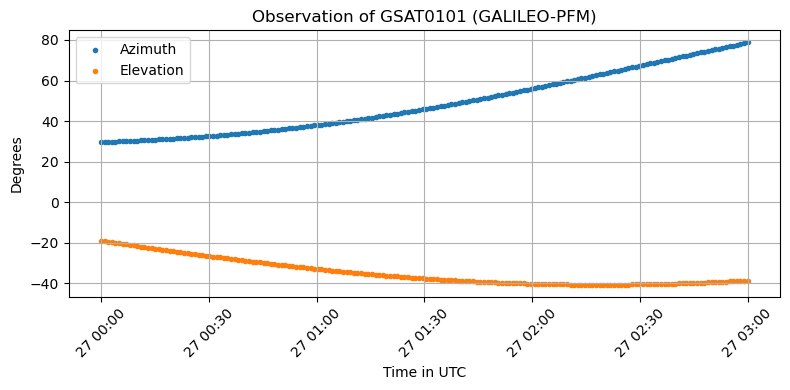

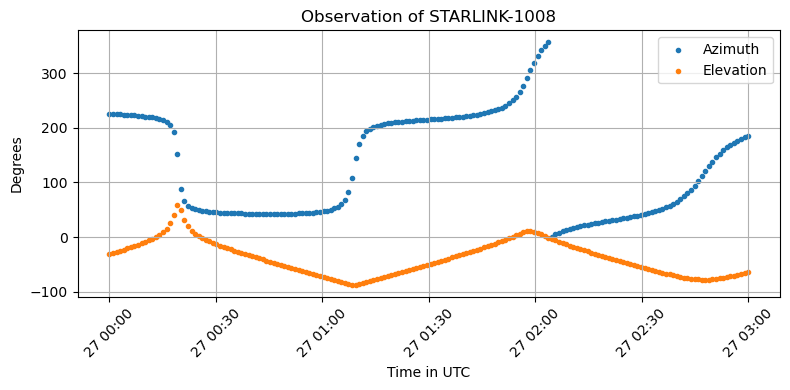

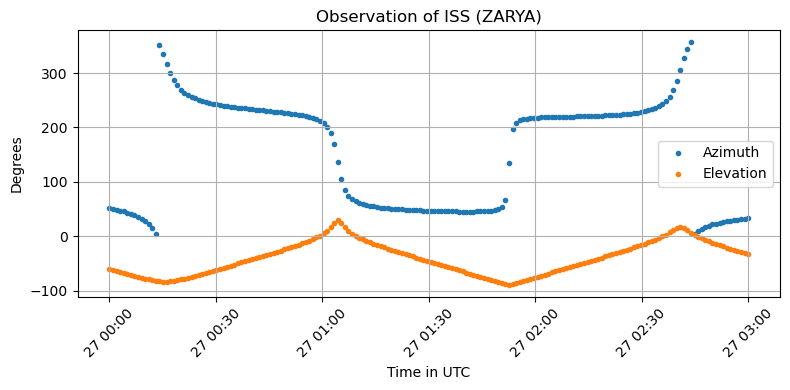

In [10]:
targets = ["GSAT0101 (GALILEO-PFM)","STARLINK-1008","ISS (ZARYA)"]

station_name ='REY30'
geodetic_position = {'REY30': [250,-29.0464, 115.3456]}    # alt, lat, lon (m,deg,deg)

# Select the global frame and orientation 
global_frame_origin = 'Earth'
global_frame_orientation = 'J2000'

# Initializing TLE from celestrack
tle_ISS_line1 = "1 25544U 98067A   25147.20450743  .00010885  00000+0  20003-3 0  9993"
tle_ISS_line2 = "2 25544  51.6384  51.0343 0002206 149.5344 343.0812 15.49769564511908"

  
tle_galileo_line1 = "1 37846U 11060A   25144.52916540 -.00000075  00000+0  00000+0 0  9995"
tle_galileo_line2 = "2 37846  57.0978 352.2961 0003612  39.4719 320.5962  1.70475644 84499"

         
tle_starlink_line1 = "1 44714U 19074B   25145.95841286  .00000108  00000+0  26155-4 0  9992"
tle_starlink_line2 = "2 44714  53.0564  38.2925 0002036  81.0993 279.0226 15.06391243305386"

tle_line1 = ["1 37846U 11060A   25144.52916540 -.00000075  00000+0  00000+0 0  9995","1 44714U 19074B   25145.95841286  .00000108  00000+0  26155-4 0  9992","1 25544U 98067A   25147.20450743  .00010885  00000+0  20003-3 0  9993"]
tle_line2 = ["2 37846  57.0978 352.2961 0003612  39.4719 320.5962  1.70475644 84499","2 44714  53.0564  38.2925 0002036  81.0993 279.0226 15.06391243305386","2 25544  51.6384  51.0343 0002206 149.5344 343.0812 15.49769564511908"]

tles = dict()
for idx in range (0,len(targets)):
    temp_time_utc = tle_line1[idx][18:32]
    temp_time_utc_fl = float(temp_time_utc)
    temp_time_tt = temp_time_utc_fl #- 0.00081019
    temp_time_tt_fl = f"{temp_time_tt:.8f}".rjust(14)  # pad with spaces if needed
    tle_line1[idx] = tle_line1[idx][:18] + temp_time_tt_fl + tle_line1[idx][32:68]
    checksum = compute_tle_checksum(tle_line1[idx])
    tle_line1[idx] = tle_line1[idx] + checksum
    
    tles[targets[idx]] = Tle(tle_line1[idx],tle_line2[idx])


# Defining time window of simulation from TLE epoch to Tle epoch + 1 day
tle_epoch = tle_ISS_line1[18:32]
start_epoch = tle_epoch_to_datetime(tle_epoch)
end_epoch = start_epoch + timedelta(days=1)

time_format = '%Y-%m-%d %H:%M:%S'

# start_epoch_string = start_epoch.strftime(time_format)
# end_epoch_string = end_epoch.strftime(time_format)

# Time window corresponding to Heavens Above data
start_epoch_string = "2025-05-27 00:00:00"
end_epoch_string = "2025-05-27 03:00:00"

time_step = '1m'

bodies_to_create = ["Earth"]

# Get start and end time in UTS, Julian Day and seconds since J2000
jd_start_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(start_epoch_string, time_format))
jd_end_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(end_epoch_string, time_format))
n_day_buffer = 0.1

utc_simulation_start_epoch = time_conversion.julian_day_to_calendar_date(jd_start_epoch - n_day_buffer)
utc_simulation_end_epoch = time_conversion.julian_day_to_calendar_date(jd_end_epoch + n_day_buffer)

sim_seconds_start_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_start_epoch - n_day_buffer) 
sim_seconds_end_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_end_epoch + n_day_buffer) 

actual_seconds_start_epoch  = time_conversion.julian_day_to_seconds_since_epoch(jd_start_epoch) 
actual_seconds_end_epoch  = time_conversion.julian_day_to_seconds_since_epoch(jd_end_epoch) 

actual_time_array = np.linspace(actual_seconds_start_epoch, actual_seconds_end_epoch, math.floor((actual_seconds_end_epoch-actual_seconds_start_epoch)/60))

# CREATE EARTH SETTINGS
body_settings = environment_setup.get_default_body_settings_time_limited(bodies_to_create, sim_seconds_start_epoch, sim_seconds_end_epoch, global_frame_origin, global_frame_orientation)
for target in targets:
    body_settings.add_empty_settings(target)

# Earth shape
eq_rad = 6378*1e3 # in meters
flat = 1/298
body_settings.get('Earth').shape_settings = environment_setup.shape.oblate_spherical(equatorial_radius = eq_rad,flattening = flat)

# Add Earth Rotation model
body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
    environment_setup.rotation_model.iau_2006, global_frame_orientation,
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60))


# Get propogated satellite coordinates from tudat propogator
states = dict()
for target in targets:
    states[target] = sat_prop(sim_seconds_start_epoch, sim_seconds_end_epoch-60, target, tles[target])

# 1) Build a dict-of-dicts of ephemeris samples:
targets_states_dicts = {
    target: {
        float(row[0]): row[1:].reshape((6,1))
        for row in state
    }
    for target, state in states.items()
}

# 2) Assign each one into your body_settings:
for target, state in targets_states_dicts.items():
    body_settings.get(target).ephemeris_settings = environment_setup.ephemeris.tabulated(state,global_frame_origin,global_frame_orientation)

# Set up ground station settings
gs_alt_m = geodetic_position[station_name][0]
gs_lat_deg = geodetic_position[station_name][1]
gs_lon_deg = geodetic_position[station_name][2]

gs_settings = []
gs_settings.append(environment_setup.ground_station.basic_station(
    station_name,
    [gs_alt_m,np.deg2rad(gs_lat_deg),np.deg2rad(gs_lon_deg)],
    element_conversion.geodetic_position_type))

body_settings.get('Earth').ground_station_settings = gs_settings

bodies = environment_setup.create_system_of_bodies(body_settings)

for target,state in targets_states_dicts.items():
    link_ends = {
        observation.receiver: observation.body_reference_point_link_end_id('Earth', target)
        }

    angles_range = estimation.compute_target_angles_and_range(
        bodies = bodies,
        station_id = ('Earth', station_name),
        target_body = target,
        observation_times = actual_time_array,
        is_station_transmitting = False  # Station is the receiver
    )

    elevations = []
    azimuths = []
    times_filtered = []

    for t in sorted(angles_range.keys()):
        elevation_rad, azimuth_rad, range_m = angles_range[t]
        
        elevations.append(np.rad2deg(elevation_rad))
        azimuths.append(np.rad2deg(azimuth_rad) % 360)  # normalize to [0, 360)
        times_filtered.append(t)

    times_filtered_utc = []
    for time_change in times_filtered:
        time_change_jd = time_conversion.seconds_since_epoch_to_julian_day(time_change)
        time_change_utc = time_conversion.julian_day_to_calendar_date(time_change_jd)
        times_filtered_utc.append(time_change_utc)

    plt.figure(figsize=(8, 4))
    plt.scatter(times_filtered_utc,azimuths,marker='.',label='Azimuth')
    plt.scatter(times_filtered_utc,elevations,marker='.',label='Elevation')
    plt.title('Observation of '+target)
    plt.xlabel('Time in UTC')
    plt.ylabel('Degrees')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()




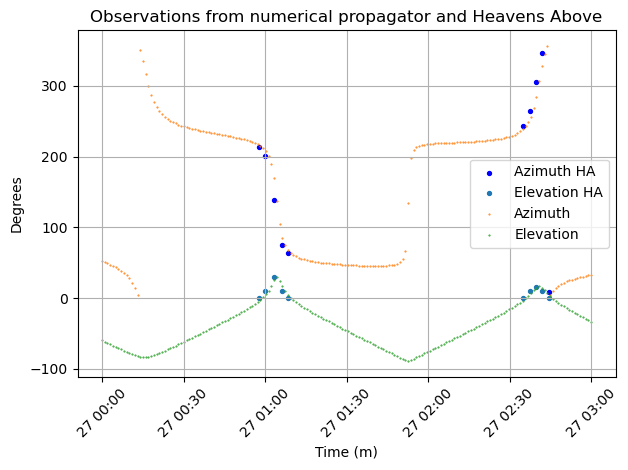

In [11]:
iss_passes = {'2025-05-27 00:57:50': [0,213],
              "2025-05-27 01:00:07": [10,201],
              "2025-05-27 01:03:09": [30, 138],
              "2025-05-27 01:06:11":[10,75],
              "2025-05-27 01:08:26":[0,64],
              "2025-05-27 02:34:51":[0,243],
              "2025-05-27 02:37:30":[10,265],
              "2025-05-27 02:39:43":[16,306],
              "2025-05-27 02:41:54":[10,347],
              "2025-05-27 02:44:32":[0,9]}

times_ha = []
elevations_ha = []
azimuths_ha = []

for t_str, (el, az) in iss_passes.items():
    dt = datetime.strptime(t_str, "%Y-%m-%d %H:%M:%S")
    times_ha.append(dt)
    elevations_ha.append(el)
    azimuths_ha.append(az)

# fig, ax = plt.subplots(figsize=(8,4))
plt.scatter(times_ha, azimuths_ha,  s=8,c='b',marker='o', label='Azimuth HA')
plt.scatter(times_ha, elevations_ha, s=8,marker='o', label='Elevation HA')
plt.scatter(times_filtered_utc,azimuths,s=1,marker='.',label='Azimuth')
plt.scatter(times_filtered_utc,elevations,s=1,marker='.',label='Elevation')

plt.title('Observations from numerical propagator and Heavens Above')
plt.xlabel('Time (m)')
plt.ylabel('Degrees')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [12]:
import bisect
HA_times_string = list(iss_passes.keys())
HA_times_JD = np.zeros(len(HA_times_string))
HA_times_sec = np.zeros(len(HA_times_string))

for idx,time_string in enumerate(HA_times_string):
    HA_times_JD[idx] = time_conversion.calendar_date_to_julian_day(datetime.strptime(HA_times_string[idx], time_format))
    HA_times_sec[idx] = time_conversion.julian_day_to_seconds_since_epoch(HA_times_JD[idx])


# n = len(azimuths)
# k = 1
# # azimuths = [0]*k + azimuths[:n-k]
# # elevations = [0]*k + elevations[:n-k]
# azimuths = azimuths[k:] + [0]*k
# elevations = elevations[k:] + [0]*k

# idx_check = np.zeros(len(HA_times_string))
elevations_check = np.zeros(len(HA_times_string))
azimuths_check = np.zeros(len(HA_times_string))

for idx,_ in enumerate(HA_times_string):
    idx_check = bisect.bisect_left(times_filtered,HA_times_sec[idx])
    elevations_check[idx] = elevations[idx_check]
    azimuths_check[idx] = azimuths[idx_check]

elevations_check_int = [int(round(x)) for x in elevations_check]
azimuths_check_int = [int(round(x)) for x in azimuths_check]

print(azimuths_ha)
print(azimuths_check_int)
print(elevations_ha)
print(elevations_check_int)






[213, 201, 138, 75, 64, 243, 265, 306, 347, 9]
[215, 208, 170, 85, 64, 239, 256, 285, 345, 4]
[0, 10, 30, 10, 0, 0, 10, 16, 10, 0]
[-2, 5, 25, 16, 1, -4, 7, 15, 11, 3]


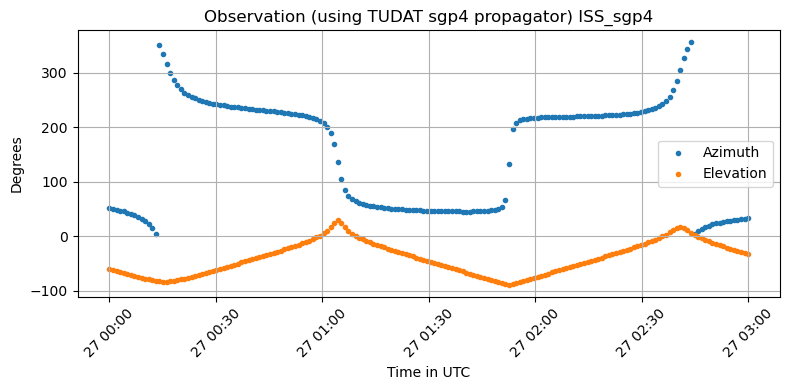

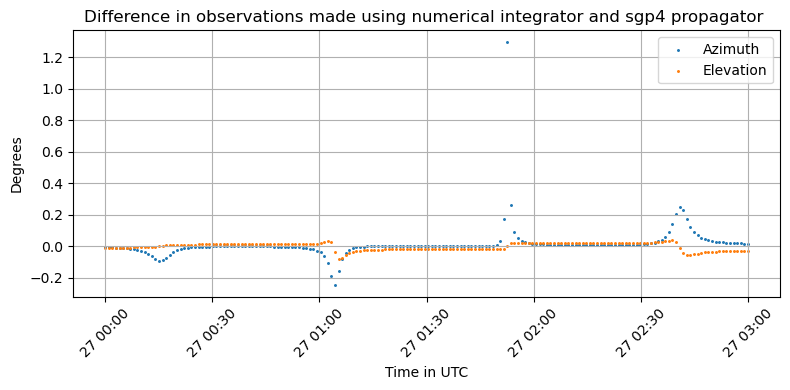

In [13]:
target_sgp4 = 'ISS_sgp4'

body_settings.add_empty_settings(target_sgp4)

body_settings.get(target_sgp4).ephemeris_settings = environment_setup.ephemeris.sgp4(tle_ISS_line1,tle_ISS_line2,'Earth','J2000')

bodies = environment_setup.create_system_of_bodies(body_settings)


angles_range_sgp4 = estimation.compute_target_angles_and_range(
    bodies = bodies,
    station_id = ('Earth', station_name),
    target_body = target_sgp4,
    observation_times = actual_time_array,
    is_station_transmitting = False  # Station is the receiver
    )

elevations_sgp4 = []
azimuths_sgp4 = []
times_filtered_sgp4 = []

for t in sorted(angles_range.keys()):
    elevation_rad_sgp4, azimuth_rad_sgp4, range_m_sgp4 = angles_range_sgp4[t]
    
    elevations_sgp4.append(np.rad2deg(elevation_rad_sgp4))
    azimuths_sgp4.append(np.rad2deg(azimuth_rad_sgp4) % 360)  # normalize to [0, 360)
    times_filtered_sgp4.append(t)

times_filtered_utc_sgp4 = []
for time_change in times_filtered_sgp4:
    time_change_jd = time_conversion.seconds_since_epoch_to_julian_day(time_change)
    time_change_utc = time_conversion.julian_day_to_calendar_date(time_change_jd)
    times_filtered_utc_sgp4.append(time_change_utc)

plt.figure(figsize=(8, 4))
plt.scatter(times_filtered_utc_sgp4,azimuths_sgp4,marker='.',label='Azimuth')
plt.scatter(times_filtered_utc_sgp4,elevations_sgp4,marker='.',label='Elevation')
plt.title('Observation (using TUDAT sgp4 propagator) '+target_sgp4)
plt.xlabel('Time in UTC')
plt.ylabel('Degrees')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


plt.figure(figsize=(8, 4))
plt.scatter(times_filtered_utc_sgp4,np.subtract(azimuths,azimuths_sgp4),s=5,marker='.',label='Azimuth')
plt.scatter(times_filtered_utc_sgp4,np.subtract(elevations, elevations_sgp4),s=5,marker='.',label='Elevation')
plt.title('Difference in observations made using numerical integrator and sgp4 propagator ')
plt.xlabel('Time in UTC')
plt.ylabel('Degrees')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



